In [2]:
import torch
import math
import datetime
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torch import Tensor
from typing import List
from lion_pytorch import Lion
from itertools import compress
from collections import OrderedDict
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class SimpleNeuralNetwork(nn.Module):
    
    def __init__(self, layers):
        super(SimpleNeuralNetwork, self).__init__()
        
        self._depth = len(layers) - 1
        self._activation_function = torch.nn.Tanh
        layers_list = list()
        
        for i in range(self._depth - 1): 
            layers_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], dtype=torch.complex128)))
            layers_list.append(('activation_%d' % i, self._activation_function()))
            
        layers_list.append(('layer_%d' % (self._depth - 1), torch.nn.Linear(layers[-2], layers[-1], dtype=torch.complex128)))
        layerDict = OrderedDict(layers_list)
        self._layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self._layers(x)
        return out

In [4]:
class ComplexLion(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-4, weight_decay=1e-2, use_triton=False):
        self.defaults = dict(lr=lr, weight_decay=weight_decay, use_triton=use_triton)
        super(ComplexLion, self).__init__(params, self.defaults)

        # Split complex parameters into real and imaginary parts
        real_params = []
        imag_params = []
        self.is_imag = []
        for param_group in self.param_groups:
            for param in param_group["params"]:
                if param.is_complex():
                    real_param = param.real.clone().detach().requires_grad_(True)
                    imag_param = param.imag.clone().detach().requires_grad_(True)
                    real_params.append(real_param)
                    imag_params.append(imag_param)
                    self.is_imag.append(True)
                else:
                    real_params.append(param)
                    self.is_imag.append(False)

        # Create two Lion optimizers, one for real parts and one for imaginary parts
        self.real_optimizer = Lion(real_params, **self.defaults)
        self.imag_optimizer = Lion(imag_params, **self.defaults)
        
    @torch.no_grad()
    def step(self, closure):
        # Define a closure for real parts
        def real_closure():
            real_loss = closure()
            if real_loss is not None:
                real_loss.backward(retain_graph=True)
            return real_loss

        # Define a closure for imaginary parts
        def imag_closure():
            imag_loss = closure()
            if imag_loss is not None:
                imag_loss.backward()
            return imag_loss

        # Optimize real and imaginary parts separately
        with torch.enable_grad():
            real_loss = self.real_optimizer.step(real_closure)
            imag_loss = self.imag_optimizer.step(imag_closure)

        # Update the original complex parameters with the optimized real and imaginary parts
        for param_group, real_param_group, imag_param_group in zip(self.param_groups, self.real_optimizer.param_groups, self.imag_optimizer.param_groups):
            for param, real_param, imag_param in zip(compress(param_group["params"], self.is_imag), compress(real_param_group["params"],self.is_imag), imag_param_group["params"]):
                if param.is_complex():
                    with torch.no_grad():
                        param.copy_(torch.complex(real_param, imag_param))

        return real_loss

In [15]:
class PINN:
    def __init__(self, X, u, layers):
        
        self.x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex128).to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex128).to(device)
        self.t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex128).to(device)          
        self.u = torch.tensor(u, requires_grad=True, dtype=torch.complex128).to(device)
        
        self.myu = torch.tensor([0.0], dtype=torch.float64, requires_grad=True).to(device)
        self.myu = torch.nn.Parameter(self.myu)
        
        self.dnn = SimpleNeuralNetwork(layers).to(device)
        self.dnn.register_parameter('myu', self.myu)

        params_list = list(self.dnn.parameters())
        
        self.optimizer = ComplexLion(
            params = params_list,
            lr = 1.0
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
        self.u_loss_history = []
        self.f_loss_history = []
        self.total_loss_history = []
        self.myu_history = []
        self.u_history = []

    def net_u(self, x, y, t):
        u = self.dnn(torch.cat([x, y, t], dim=1))
        return u
    
    def net_f(self, x, y, t):
        myu = self.myu 
        u = self.net_u(x, y, t)
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t - myu*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u
        del u_t
        del u_x
        del u_y
        del u_xx
        del u_yy
        torch.cuda.empty_cache()
        return f
    
    def loss_func(self):
        
        u_pred = self.net_u(self.x, self.y, self.t)
        f_pred = self.net_f(self.x, self.y, self.t)

        u_loss = torch.abs(torch.mean((self.u[3, 3, 399, 0] - u_pred) ** 2))
        f_loss = torch.abs(torch.mean(f_pred ** 2))
        
        loss = u_loss + f_loss
        
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        
        self.iter += 1
        if self.iter % 10 == 0:
            print('Iter: %d, u_loss: %s, f_loss: %s, total loss: %s, myu: %s \n' % 
                    (
                        self.iter,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(), 
                        self.myu.item()
                    )
                )
        
        self.u_loss_history.append(u_loss.item())
        self.f_loss_history.append(f_loss.item())
        self.total_loss_history.append(loss.item())
        self.myu_history.append(self.myu.item())
        self.u_history.append(u_pred)
        
        del u_loss
        del f_loss
        torch.cuda.empty_cache()
        return loss

    def train(self, epochs):
        
        self.dnn.train()
        
        self.u_loss_history = []
        self.f_loss_history = []
        self.myu_history = []
        self.u_history = []
        self.total_loss_history = []
        
        for epoch in tqdm(range(epochs)):
            
            u_pred = self.net_u(self.x, self.y, self.t)
            f_pred = self.net_f(self.x, self.y, self.t)
            
            u_loss = torch.abs(torch.mean((self.u[3, 3, 399, 0] - u_pred) ** 2))
            f_loss = torch.abs(torch.mean(f_pred ** 2))
                    
            loss = u_loss + f_loss
            
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print('It: %d, u_loss: %s, f_loss: %s, total loss: %s, myu: %s \n' % 
                    (
                        epoch,
                        u_loss.item(),
                        f_loss.item(),
                        loss.item(), 
                        self.myu.item()
                    )
                )
            
            self.u_loss_history.append(u_loss.item())
            self.f_loss_history.append(f_loss.item())
            self.total_loss_history.append(loss.item())
            self.myu_history.append(self.myu.item())
            self.u_history.append(u_pred)
            
            del u_loss
            del f_loss
            del u_pred
            torch.cuda.empty_cache()
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        
        x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.complex128).to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.complex128).to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True, dtype=torch.complex128).to(device)  

        self.dnn.eval()
        
        u = self.net_u(x, y, t)
        f = self.net_f(x, y, t)
        
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        
        return u, f

In [21]:
A_original = np.load('A_original.npy')
myu_target = np.load('myu_original.npy')
X_star = np.load('X_star.npy')

In [23]:
X_star.shape

(16000, 3)

In [17]:
A_original.shape

(1, 1000, 4, 4)

100%|██████████| 1000/1000 [01:37<00:00, 10.29it/s]


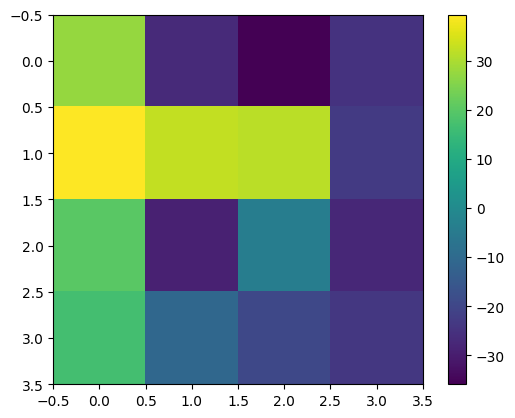

In [18]:
for index in tqdm(range(A_original.shape[1])):
    if index % 2 == 0:
        plt.clf()
        plt.imshow(A_original.reshape(A_original.shape[1], A_original.shape[2], A_original.shape[3]).imag[index, :, :]*\
                   A_original.reshape(A_original.shape[1], A_original.shape[2], A_original.shape[3]).real[index, :, :])
        plt.colorbar()

In [24]:
snn_layers = [3, 20, 20, 20, 20, 1]

x = X_star[0:1]
y = X_star[1:2]
t = X_star[2:3]

Exact = A_original.T

X, Y, T = np.meshgrid(x, y, t)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact

In [32]:
model = PINN(
    X=X_star,
    u=u_star,
    layers=snn_layers
)

In [33]:
model.train(10000)

  0%|          | 7/10000 [00:00<02:32, 65.60it/s]

It: 0, u_loss: 75.05586803876325, f_loss: 0.22760509181815805, total loss: 75.28347313058141, myu: -0.000999999970525036 



  1%|          | 113/10000 [00:01<02:09, 76.63it/s]

It: 100, u_loss: 48.3236025665848, f_loss: 0.598951531673353, total loss: 48.92255409825815, myu: 0.04605793106708815 



  2%|▏         | 211/10000 [00:02<02:06, 77.54it/s]

It: 200, u_loss: 42.32918539146771, f_loss: 0.4085530200031811, total loss: 42.73773841147089, myu: 0.09213483767778069 



  3%|▎         | 312/10000 [00:05<02:11, 73.73it/s]

It: 300, u_loss: 41.35093877005258, f_loss: 41.15364698221298, total loss: 82.50458575226557, myu: 0.13251939191418996 



  4%|▍         | 410/10000 [00:06<02:03, 77.37it/s]

It: 400, u_loss: 50.24628822013535, f_loss: 0.5500531727556814, total loss: 50.79634139289103, myu: 0.18782312746971955 



  5%|▌         | 516/10000 [00:08<02:54, 54.22it/s]

It: 500, u_loss: 45.901188598347034, f_loss: 0.28161377996926473, total loss: 46.182802378316296, myu: 0.26241134912039127 



  6%|▌         | 615/10000 [00:09<01:59, 78.27it/s]

It: 600, u_loss: 32.77857308181067, f_loss: 1.348467806365691, total loss: 34.12704088817636, myu: 0.31896239534982107 



  7%|▋         | 703/10000 [00:11<02:10, 71.09it/s]

It: 700, u_loss: 29.653087309928576, f_loss: 1.208128617072658, total loss: 30.861215927001233, myu: 0.34720354921183166 



  8%|▊         | 811/10000 [00:13<02:24, 63.69it/s]

It: 800, u_loss: 31.129065919094792, f_loss: 1.3920584915853438, total loss: 32.52112441068014, myu: 0.36440549716857207 



  9%|▉         | 902/10000 [00:15<02:43, 55.74it/s]

It: 900, u_loss: 31.308662089741794, f_loss: 2.1527242990702713, total loss: 33.461386388812066, myu: 0.3817258627382904 



 10%|█         | 1007/10000 [00:17<02:35, 57.70it/s]

It: 1000, u_loss: 42.23907853364881, f_loss: 0.4760940960857912, total loss: 42.715172629734596, myu: 0.39462415168484694 



 11%|█         | 1101/10000 [00:19<01:56, 76.53it/s]

It: 1100, u_loss: 34.31700774921799, f_loss: 0.17233992101605364, total loss: 34.48934767023405, myu: 0.4208025849530558 



 12%|█▏        | 1211/10000 [00:21<01:57, 74.51it/s]

It: 1200, u_loss: 31.61844160066736, f_loss: 0.6824270491036113, total loss: 32.30086864977097, myu: 0.437580442671247 



 13%|█▎        | 1308/10000 [00:22<01:55, 75.44it/s]

It: 1300, u_loss: 29.547750124000707, f_loss: 1.8234811868177103, total loss: 31.371231310818416, myu: 0.45462055259201534 



 14%|█▍        | 1410/10000 [00:24<02:11, 65.38it/s]

It: 1400, u_loss: 26.17160244307087, f_loss: 2.785192311050572, total loss: 28.956794754121443, myu: 0.47044492332091725 



 15%|█▌        | 1507/10000 [00:26<01:50, 76.77it/s]

It: 1500, u_loss: 25.165168543938538, f_loss: 2.8349152257607266, total loss: 28.000083769699266, myu: 0.48707960172238896 



 16%|█▌        | 1612/10000 [00:28<03:53, 35.86it/s]

It: 1600, u_loss: 23.8254086387212, f_loss: 9.378667544428616, total loss: 33.204076183149816, myu: 0.5052915153148055 



 17%|█▋        | 1710/10000 [00:30<02:12, 62.44it/s]

It: 1700, u_loss: 25.91865539227373, f_loss: 1.9275263884362486, total loss: 27.84618178070998, myu: 0.5207397281048388 



 18%|█▊        | 1808/10000 [00:32<04:23, 31.11it/s]

It: 1800, u_loss: 24.279177256006406, f_loss: 0.393270813421494, total loss: 24.6724480694279, myu: 0.5367073973336695 



 19%|█▉        | 1908/10000 [00:34<01:48, 74.55it/s]

It: 1900, u_loss: 22.54953311402135, f_loss: 1.0017393093905869, total loss: 23.551272423411937, myu: 0.553531028835487 



 20%|█▉        | 1998/10000 [00:35<01:44, 76.78it/s]

It: 2000, u_loss: 19.800606411261132, f_loss: 1.2608617026634144, total loss: 21.061468113924548, myu: 0.5654839834697601 



 21%|██        | 2115/10000 [00:37<01:49, 71.93it/s]

It: 2100, u_loss: 25.464186789739834, f_loss: 1.5710112301330323, total loss: 27.035198019872865, myu: 0.5802975424966598 



 22%|██▏       | 2211/10000 [00:39<01:47, 72.58it/s]

It: 2200, u_loss: 23.750208040408175, f_loss: 2.8759001138128233, total loss: 26.626108154220997, myu: 0.5892942551141163 



 23%|██▎       | 2311/10000 [00:41<01:52, 68.05it/s]

It: 2300, u_loss: 22.405441744127696, f_loss: 15.279636316493278, total loss: 37.685078060620974, myu: 0.5992840478331585 



 24%|██▍       | 2414/10000 [00:42<01:39, 76.15it/s]

It: 2400, u_loss: 19.550378862289378, f_loss: 8.298649104827973, total loss: 27.84902796711735, myu: 0.6093100223380642 



 25%|██▌       | 2512/10000 [00:44<02:55, 42.75it/s]

It: 2500, u_loss: 19.746304953648007, f_loss: 28.758174086838096, total loss: 48.5044790404861, myu: 0.6162526166896176 



 26%|██▌       | 2608/10000 [00:46<01:58, 62.30it/s]

It: 2600, u_loss: 16.802678959024433, f_loss: 12.95617682766578, total loss: 29.758855786690212, myu: 0.6246697569463803 



 27%|██▋       | 2713/10000 [00:48<02:41, 45.14it/s]

It: 2700, u_loss: 21.80805154492889, f_loss: 0.3379178084313629, total loss: 22.145969353360254, myu: 0.630243749032579 



 28%|██▊       | 2806/10000 [00:50<01:38, 73.16it/s]

It: 2800, u_loss: 21.104386691420178, f_loss: 1.6887266509960788, total loss: 22.793113342416255, myu: 0.6396406705101373 



 29%|██▉       | 2903/10000 [00:51<01:34, 75.09it/s]

It: 2900, u_loss: 21.68110968878766, f_loss: 1.3803554910361822, total loss: 23.06146517982384, myu: 0.6458910990294625 



 30%|███       | 3008/10000 [00:53<01:42, 67.92it/s]

It: 3000, u_loss: 18.901687572953904, f_loss: 1.9339237322660972, total loss: 20.835611305220002, myu: 0.6519417176189284 



 31%|███       | 3113/10000 [00:55<01:34, 73.08it/s]

It: 3100, u_loss: 20.348044486405474, f_loss: 3.6447976438158567, total loss: 23.99284213022133, myu: 0.6596422083541281 



 32%|███▏      | 3212/10000 [00:57<01:36, 70.52it/s]

It: 3200, u_loss: 18.81682209761417, f_loss: 0.5113272626105008, total loss: 19.32814936022467, myu: 0.6635703645305036 



 33%|███▎      | 3312/10000 [00:58<01:25, 78.16it/s]

It: 3300, u_loss: 19.09196185159718, f_loss: 5.920066704587615, total loss: 25.012028556184795, myu: 0.6710672880576815 



 34%|███▍      | 3409/10000 [01:00<02:26, 45.11it/s]

It: 3400, u_loss: 20.71423985210029, f_loss: 1.251310711089442, total loss: 21.965550563189733, myu: 0.6761816302843808 



 35%|███▌      | 3508/10000 [01:02<01:44, 62.14it/s]

It: 3500, u_loss: 16.848610504441776, f_loss: 7.923449793041697, total loss: 24.772060297483474, myu: 0.6829232168079116 



 36%|███▌      | 3609/10000 [01:05<02:04, 51.50it/s]

It: 3600, u_loss: 16.290459566696278, f_loss: 8.041530758431412, total loss: 24.33199032512769, myu: 0.6881784934479636 



 37%|███▋      | 3712/10000 [01:06<01:20, 78.56it/s]

It: 3700, u_loss: 16.939282709962203, f_loss: 0.645883719316245, total loss: 17.58516642927845, myu: 0.6921037686116692 



 38%|███▊      | 3802/10000 [01:08<03:05, 33.36it/s]

It: 3800, u_loss: 18.172884511195385, f_loss: 2.774550579730582, total loss: 20.947435090925968, myu: 0.6975429179978546 



 39%|███▉      | 3916/10000 [01:09<01:20, 75.27it/s]

It: 3900, u_loss: 18.759758463047646, f_loss: 2.515899373100519, total loss: 21.275657836148167, myu: 0.7015204742315971 



 40%|████      | 4011/10000 [01:11<01:22, 72.81it/s]

It: 4000, u_loss: 15.301777664913034, f_loss: 7.02098091169118, total loss: 22.322758576604215, myu: 0.7067057161933792 



 41%|████      | 4108/10000 [01:13<01:26, 68.27it/s]

It: 4100, u_loss: 16.180778319677017, f_loss: 31.138568994111544, total loss: 47.31934731378856, myu: 0.7115661247832031 



 42%|████▏     | 4212/10000 [01:14<01:25, 68.01it/s]

It: 4200, u_loss: 16.028074996015036, f_loss: 1.2968036551518842, total loss: 17.32487865116692, myu: 0.7160672388746442 



 43%|████▎     | 4307/10000 [01:17<01:52, 50.60it/s]

It: 4300, u_loss: 17.677119926903824, f_loss: 2.035856528856479, total loss: 19.7129764557603, myu: 0.7209022672840529 



 44%|████▍     | 4411/10000 [01:18<01:32, 60.29it/s]

It: 4400, u_loss: 13.936546430688251, f_loss: 7.2285140776605665, total loss: 21.165060508348816, myu: 0.725111324269779 



 45%|████▌     | 4508/10000 [01:21<01:40, 54.60it/s]

It: 4500, u_loss: 17.211341687416986, f_loss: 6.304800355011313, total loss: 23.5161420424283, myu: 0.7291659143773934 



 46%|████▌     | 4611/10000 [01:22<01:15, 70.97it/s]

It: 4600, u_loss: 17.26490632044109, f_loss: 8.446904771597438, total loss: 25.711811092038527, myu: 0.734173017548962 



 47%|████▋     | 4713/10000 [01:24<01:44, 50.59it/s]

It: 4700, u_loss: 16.67485773845319, f_loss: 1.406568982771962, total loss: 18.081426721225153, myu: 0.7377354427012246 



 48%|████▊     | 4813/10000 [01:26<01:10, 73.70it/s]

It: 4800, u_loss: 13.63167315563058, f_loss: 1.8735892943545323, total loss: 15.505262449985112, myu: 0.7419249525367017 



 49%|████▉     | 4905/10000 [01:27<01:04, 78.63it/s]

It: 4900, u_loss: 16.82929481700488, f_loss: 0.7498327244726554, total loss: 17.579127541477533, myu: 0.7451456957952536 



 50%|█████     | 5014/10000 [01:29<01:06, 75.30it/s]

It: 5000, u_loss: 15.943696850604393, f_loss: 23.146843925835135, total loss: 39.090540776439525, myu: 0.750213423748273 



 51%|█████     | 5111/10000 [01:31<01:08, 70.98it/s]

It: 5100, u_loss: 14.957637238167894, f_loss: 0.722689858109656, total loss: 15.68032709627755, myu: 0.7529568881061337 



 52%|█████▏    | 5206/10000 [01:33<01:41, 47.36it/s]

It: 5200, u_loss: 14.36276935416331, f_loss: 1.351930323466291, total loss: 15.714699677629602, myu: 0.757177791836215 



 53%|█████▎    | 5309/10000 [01:35<01:19, 59.05it/s]

It: 5300, u_loss: 15.654247846304049, f_loss: 0.3033966126200363, total loss: 15.957644458924085, myu: 0.7601264191429669 



 54%|█████▍    | 5413/10000 [01:37<01:14, 61.45it/s]

It: 5400, u_loss: 14.572026410774498, f_loss: 2.81563118492366, total loss: 17.38765759569816, myu: 0.7646765514458598 



 55%|█████▌    | 5509/10000 [01:38<01:00, 74.35it/s]

It: 5500, u_loss: 14.985319986582159, f_loss: 0.5010819428865428, total loss: 15.486401929468702, myu: 0.7675074019685121 



 56%|█████▌    | 5610/10000 [01:41<01:18, 55.69it/s]

It: 5600, u_loss: 12.985675993312205, f_loss: 11.378904614972395, total loss: 24.364580608284598, myu: 0.7700877427432204 



 57%|█████▋    | 5707/10000 [01:42<01:00, 71.52it/s]

It: 5700, u_loss: 15.23256171565896, f_loss: 7.519414902393831, total loss: 22.75197661805279, myu: 0.7745631044174881 



 58%|█████▊    | 5805/10000 [01:44<02:43, 25.68it/s]

It: 5800, u_loss: 15.089865462091726, f_loss: 4.770273988729187, total loss: 19.860139450820913, myu: 0.7784055342961407 



 59%|█████▉    | 5911/10000 [01:46<00:53, 76.06it/s]

It: 5900, u_loss: 14.217771822888912, f_loss: 2.024431086596732, total loss: 16.242202909485645, myu: 0.7804728578532195 



 60%|██████    | 6007/10000 [01:47<00:56, 70.49it/s]

It: 6000, u_loss: 15.021718691704697, f_loss: 1.2132608635650386, total loss: 16.234979555269735, myu: 0.784768220165905 



 61%|██████    | 6108/10000 [01:49<01:06, 58.67it/s]

It: 6100, u_loss: 14.645888845692365, f_loss: 2.282347250680513, total loss: 16.928236096372878, myu: 0.7883444770234623 



 62%|██████▏   | 6208/10000 [01:51<01:03, 59.60it/s]

It: 6200, u_loss: 12.115429541835544, f_loss: 1.96397214628138, total loss: 14.079401688116924, myu: 0.7915850961034568 



 63%|██████▎   | 6310/10000 [01:53<01:00, 61.25it/s]

It: 6300, u_loss: 15.143619044593192, f_loss: 3.644778907386626, total loss: 18.788397951979817, myu: 0.794652230795525 



 64%|██████▍   | 6414/10000 [01:55<00:47, 75.03it/s]

It: 6400, u_loss: 12.912282020800802, f_loss: 14.194090983242996, total loss: 27.106373004043796, myu: 0.7979811416331831 



 65%|██████▌   | 6514/10000 [01:57<00:48, 72.16it/s]

It: 6500, u_loss: 12.589498255810454, f_loss: 11.666672101048459, total loss: 24.256170356858913, myu: 0.8007360594693054 



 66%|██████▌   | 6611/10000 [01:58<00:44, 75.54it/s]

It: 6600, u_loss: 15.888941625316727, f_loss: 0.08851126525092014, total loss: 15.977452890567648, myu: 0.8042257411078141 



 67%|██████▋   | 6717/10000 [02:01<01:04, 50.53it/s]

It: 6700, u_loss: 13.867335840954523, f_loss: 12.27535961905886, total loss: 26.142695460013382, myu: 0.8072166873515951 



 68%|██████▊   | 6813/10000 [02:02<00:41, 76.17it/s]

It: 6800, u_loss: 14.38567046453275, f_loss: 2.968753093465093, total loss: 17.35442355799784, myu: 0.8102043381876584 



 69%|██████▉   | 6910/10000 [02:03<00:40, 77.05it/s]

It: 6900, u_loss: 12.275702028497832, f_loss: 1.5653922562581395, total loss: 13.841094284755972, myu: 0.8127265293145537 



 70%|███████   | 7008/10000 [02:06<00:50, 59.16it/s]

It: 7000, u_loss: 13.874941125996534, f_loss: 22.046171946072906, total loss: 35.92111307206944, myu: 0.8150132957462669 



 71%|███████   | 7101/10000 [02:07<00:53, 54.08it/s]

It: 7100, u_loss: 13.212660432613113, f_loss: 1.2320763438223141, total loss: 14.444736776435427, myu: 0.8182612063278657 



 72%|███████▏  | 7207/10000 [02:10<00:38, 72.16it/s]

It: 7200, u_loss: 12.361933686495794, f_loss: 5.042045131232296, total loss: 17.40397881772809, myu: 0.8211516256734854 



 73%|███████▎  | 7312/10000 [02:11<00:35, 75.23it/s]

It: 7300, u_loss: 12.765434506325745, f_loss: 0.935998461944257, total loss: 13.701432968270002, myu: 0.8241161701353775 



 74%|███████▍  | 7407/10000 [02:13<00:40, 64.47it/s]

It: 7400, u_loss: 13.352809299196561, f_loss: 0.1274252656211048, total loss: 13.480234564817666, myu: 0.827702478043905 



 75%|███████▌  | 7500/10000 [02:15<00:46, 53.86it/s]

It: 7500, u_loss: 10.789287690657506, f_loss: 2.5362228384361276, total loss: 13.325510529093634, myu: 0.8299247563268376 



 76%|███████▌  | 7610/10000 [02:18<00:38, 62.24it/s]

It: 7600, u_loss: 13.31614342087351, f_loss: 1.24843146206054, total loss: 14.56457488293405, myu: 0.8335202695396008 



 77%|███████▋  | 7706/10000 [02:21<01:12, 31.43it/s]

It: 7700, u_loss: 11.862009708716151, f_loss: 0.8579241203514154, total loss: 12.719933829067566, myu: 0.8358212197846231 



 78%|███████▊  | 7808/10000 [02:25<01:36, 22.82it/s]

It: 7800, u_loss: 12.206112361089998, f_loss: 1.9614719123043884, total loss: 14.167584273394386, myu: 0.8380916305746221 



 79%|███████▉  | 7905/10000 [02:27<00:50, 41.81it/s]

It: 7900, u_loss: 10.60740284934949, f_loss: 0.23856860213416034, total loss: 10.845971451483651, myu: 0.8404085295184719 



 80%|████████  | 8008/10000 [02:30<00:40, 49.59it/s]

It: 8000, u_loss: 11.07346569967811, f_loss: 1.064987181911187, total loss: 12.138452881589297, myu: 0.8425656428512075 



 81%|████████  | 8107/10000 [02:33<00:42, 44.56it/s]

It: 8100, u_loss: 10.937612045290717, f_loss: 41.79202481202771, total loss: 52.729636857318425, myu: 0.8455866211710409 



 82%|████████▏ | 8205/10000 [02:35<00:43, 41.13it/s]

It: 8200, u_loss: 12.09081562686896, f_loss: 0.18740924487293067, total loss: 12.278224871741891, myu: 0.848209261147057 



 83%|████████▎ | 8306/10000 [02:39<00:40, 42.18it/s]

It: 8300, u_loss: 10.986742850479272, f_loss: 1.047841387922352, total loss: 12.034584238401624, myu: 0.8503161109563288 



 84%|████████▍ | 8406/10000 [02:42<00:37, 42.29it/s]

It: 8400, u_loss: 11.600624593379179, f_loss: 15.002761644475834, total loss: 26.603386237855013, myu: 0.8530302981160482 



 85%|████████▌ | 8507/10000 [02:45<00:33, 44.53it/s]

It: 8500, u_loss: 11.549468388287492, f_loss: 11.43806310923953, total loss: 22.987531497527023, myu: 0.8553817899647993 



 86%|████████▌ | 8610/10000 [02:46<00:20, 67.49it/s]

It: 8600, u_loss: 11.555515769698703, f_loss: 0.36621893146162227, total loss: 11.921734701160325, myu: 0.8579918171751226 



 87%|████████▋ | 8710/10000 [02:49<00:37, 34.08it/s]

It: 8700, u_loss: 10.572470100693725, f_loss: 4.97129018125272, total loss: 15.543760281946444, myu: 0.8600023353848736 



 88%|████████▊ | 8808/10000 [02:50<00:16, 71.05it/s]

It: 8800, u_loss: 9.709731586931255, f_loss: 37.456461050493125, total loss: 47.16619263742438, myu: 0.8619516612459437 



 89%|████████▉ | 8903/10000 [02:52<00:31, 35.29it/s]

It: 8900, u_loss: 10.244930998758122, f_loss: 2.690429933067166, total loss: 12.935360931825288, myu: 0.8641265093916376 



 90%|█████████ | 9008/10000 [02:54<00:18, 53.13it/s]

It: 9000, u_loss: 10.35343507652887, f_loss: 9.99733892123886, total loss: 20.35077399776773, myu: 0.8668037337742163 



 91%|█████████ | 9110/10000 [02:57<00:22, 40.17it/s]

It: 9100, u_loss: 11.498550679747847, f_loss: 0.35898676894243936, total loss: 11.857537448690287, myu: 0.868431621979723 



 92%|█████████▏| 9210/10000 [02:59<00:11, 68.02it/s]

It: 9200, u_loss: 12.545520802969977, f_loss: 1.805370700560814, total loss: 14.350891503530791, myu: 0.8713026140528717 



 93%|█████████▎| 9313/10000 [03:01<00:12, 52.96it/s]

It: 9300, u_loss: 11.256354721336539, f_loss: 2.792855690010799, total loss: 14.049210411347339, myu: 0.8735274590840734 



 94%|█████████▍| 9407/10000 [03:02<00:09, 61.71it/s]

It: 9400, u_loss: 12.424267511436259, f_loss: 0.8038986293557066, total loss: 13.228166140791966, myu: 0.8755704204098064 



 95%|█████████▌| 9511/10000 [03:05<00:13, 35.10it/s]

It: 9500, u_loss: 10.380795780699794, f_loss: 2.0801230865485567, total loss: 12.46091886724835, myu: 0.8775396123095237 



 96%|█████████▌| 9612/10000 [03:06<00:05, 73.58it/s]

It: 9600, u_loss: 9.632393295889797, f_loss: 0.10683678256777707, total loss: 9.739230078457574, myu: 0.879623930307115 



 97%|█████████▋| 9703/10000 [03:08<00:04, 61.43it/s]

It: 9700, u_loss: 9.362715982523854, f_loss: 1.293507546907786, total loss: 10.65622352943164, myu: 0.8814045461165225 



 98%|█████████▊| 9809/10000 [03:11<00:03, 51.13it/s]

It: 9800, u_loss: 10.173268198901553, f_loss: 1.6220861693646615, total loss: 11.795354368266215, myu: 0.8839015699163174 



 99%|█████████▉| 9907/10000 [03:13<00:02, 45.35it/s]

It: 9900, u_loss: 9.800264061415332, f_loss: 3.6007702721422317, total loss: 13.401034333557563, myu: 0.8855848768750733 



100%|██████████| 10000/10000 [03:15<00:00, 51.18it/s]


In [34]:
iterations = np.linspace(0, len(model.u_loss_history), len(model.u_loss_history))
len(iterations)

10002

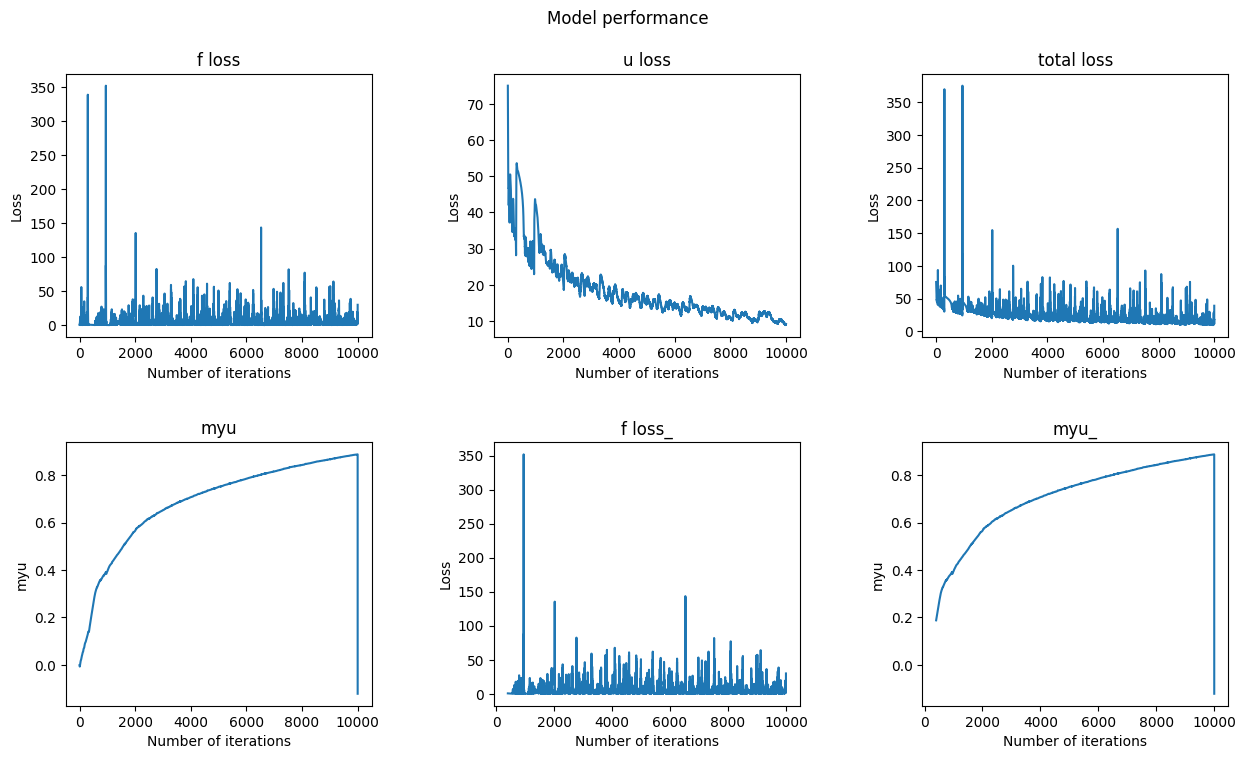

In [35]:
skip_size = 400
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0,0].plot(iterations, model.f_loss_history, label="f loss")
axs[0,0].set_xlabel('Number of iterations')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("f loss")
# axs[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0,1].plot(iterations, model.u_loss_history, label="u loss")
axs[0,1].set_xlabel('Number of iterations')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title("u loss")
# axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0,2].plot(iterations, model.total_loss_history, label="total loss")
axs[0,2].set_xlabel('Number of iterations')
axs[0,2].set_ylabel('Loss')
axs[0,2].set_title("total loss")
# axs[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,0].plot(iterations, model.myu_history, label="myu")
axs[1,0].set_xlabel('Number of iterations')
axs[1,0].set_ylabel('myu')
axs[1,0].set_title("myu")
# axs[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,1].plot(iterations[skip_size:], model.f_loss_history[skip_size:], label="f loss")
axs[1,1].set_xlabel('Number of iterations')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_title("f loss_")
# axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,2].plot(iterations[skip_size:], model.myu_history[skip_size:], label="myu")
axs[1,2].set_xlabel('Number of iterations')
axs[1,2].set_ylabel('myu')
axs[1,2].set_title("myu_")
# axs[1,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Model performance")
plt.show()

In [36]:
f_loss_norm = (model.f_loss_history - np.min(model.f_loss_history)) / (np.max(model.f_loss_history) - np.min(model.f_loss_history))
u_loss_norm = (model.u_loss_history - np.min(model.u_loss_history)) / (np.max(model.u_loss_history) - np.min(model.u_loss_history))
total_loss_norm = (model.total_loss_history - np.min(model.total_loss_history)) / (np.max(model.total_loss_history) - np.min(model.total_loss_history))

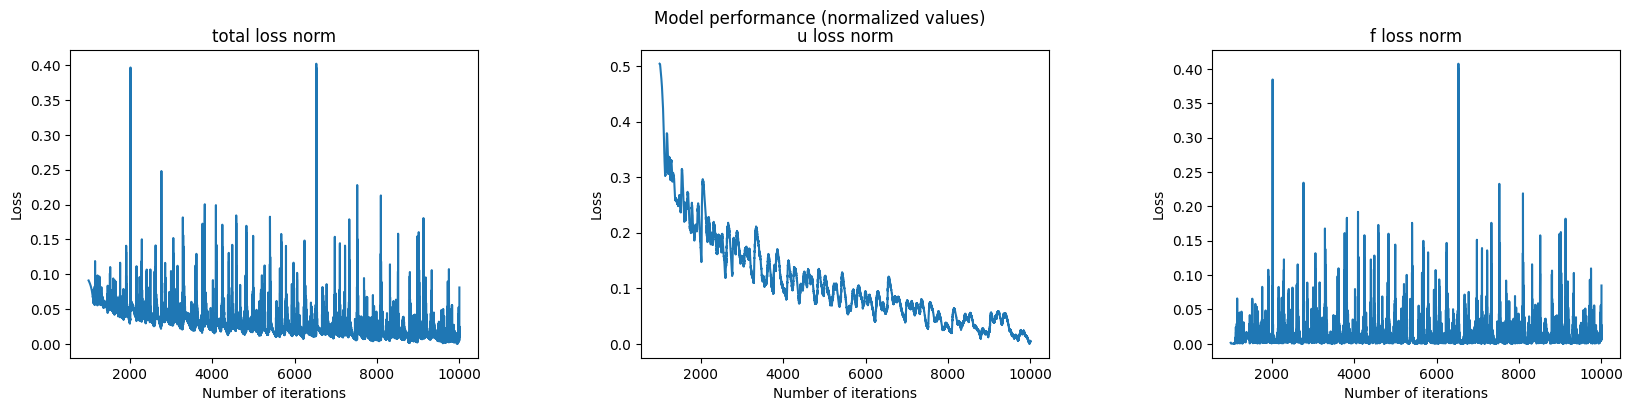

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].plot(iterations[1000:], total_loss_norm[1000:], label="total loss norm")
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Loss')
axs[0].set_title("total loss norm")
# axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1].plot(iterations[1000:], u_loss_norm[1000:], label="u loss norm")
axs[1].set_xlabel('Number of iterations')
axs[1].set_ylabel('Loss')
axs[1].set_title("u loss norm")
# axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[2].plot(iterations[1000:], f_loss_norm[1000:], label="f loss norm")
axs[2].set_xlabel('Number of iterations')
axs[2].set_ylabel('Loss')
axs[2].set_title("f loss norm")
# axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Model performance (normalized values)")
plt.show()


In [44]:
X_star = np.load('X_star.npy')

In [45]:
u_pred, f_pred = model.predict(X_star)

In [49]:
A_original.shape

(1, 1000, 4, 4)

In [52]:
u_pred = u_pred.reshape(A_original.shape[1], A_original.shape[2], A_original.shape[3])
print(u_pred.shape)

(1000, 4, 4)


100%|██████████| 1000/1000 [00:44<00:00, 22.51it/s]


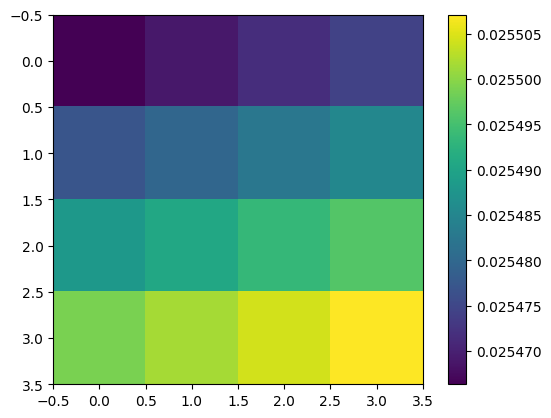

In [54]:
for index in tqdm(range(u_pred.shape[0])):
    if index % 2 == 0:
        plt.clf()
        plt.imshow(u_pred.reshape(u_pred.shape[0], u_pred.shape[1], u_pred.shape[2]).imag[index, :, :]*\
                   u_pred.reshape(u_pred.shape[0], u_pred.shape[1], u_pred.shape[2]).real[index, :, :])
        plt.colorbar()